In [1]:
#Imports
import pykep as pk
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
from pykep.planet import jpl_lp
from pykep import epoch
import numpy as np
import matplotlib.pyplot as plt
import math

# Load Spice Kernel
pk.util.load_spice_kernel("/home/m/mmk40/Desktop/Planet Position/de431.bsp")

In [2]:
# Define Launch and Arrival Dates
departure = int(pk.epoch_from_string("1925-Jan-01 00:00:00").mjd2000)  # ≈ 12784; Turns the date into mjd
arrival = int(pk.epoch_from_string("2045-Jan-01 00:00:00").mjd2000)    # ≈ 18262; Turns the date into mjd
#print(departure, arrival)                                              # print checks

In [7]:
# Define the problem i.e. Earth-Venus-Jupiter flyby with 1 DSM.
udp = pk.trajopt.mga_1dsm(
    seq=[jpl_lp('earth'), jpl_lp('venus'), jpl_lp('jupiter')],
    t0=[epoch(departure),epoch(arrival)],             # Departure window (in MJD2000)
    tof=[[100,300], [800, 1500]],        # TOF for Earth→Venus, Venus→Jupiter
    vinf=[8.0,9.0],                      # Departure hyperbolic excess speed [km/s]
    add_vinf_dep=False,                   # Objective includes v-infinity at Earth/Venus
    add_vinf_arr=False,                   # Objective includes v-infinity at Venus/Jupiter
    orbit_insertion=False
)

print(jpl_lp('earth'),jpl_lp('venus'), jpl_lp('jupiter'))

Planet Name: earth
Own gravity parameter: 398600441800000
Central body gravity parameter: 1.32712440018e+20
Planet radius: 6378000
Planet safe radius: 7015800.0000000009
Ephemerides type: JPL low-precision
 Planet Name: venus
Own gravity parameter: 324859000000000
Central body gravity parameter: 1.32712440018e+20
Planet radius: 6052000
Planet safe radius: 6657200.0000000009
Ephemerides type: JPL low-precision
 Planet Name: jupiter
Own gravity parameter: 1.26686534e+17
Central body gravity parameter: 1.32712440018e+20
Planet radius: 71492000
Planet safe radius: 643428000
Ephemerides type: JPL low-precision



In [10]:
# Create Pygmo set
prob = pg.problem(udp)

#print(prob)   # print check
#print("Lower bounds:", prob.get_lb())
#print("Upper bounds:", prob.get_ub())

# Choose optimization algorithm
uda = pg.sade(gen=1000)

# Initialize population and optimize
archi = pg.archipelago(algo=uda, prob=udp, n=40, pop_size=40)
print("Running a Self-Adaptive Differential Evolution Algorithm .... on 16 parallel islands")
archi.evolve(30)
archi.wait()
sols = archi.get_champions_f()
idx = sols.index(min(sols))
print("Done!! Solutions found are: ", archi.get_champions_f())
udp.pretty(archi.get_champions_x()[idx])

Running a Self-Adaptive Differential Evolution Algorithm .... on 16 parallel islands
Done!! Solutions found are:  [array([3278.15504981]), array([3228.35821381]), array([3424.8095995]), array([3193.75914409]), array([3278.15504987]), array([3278.71058562]), array([3644.82330391]), array([3811.9049505]), array([3790.90745602]), array([4328.86117068]), array([3193.7591441]), array([3228.35821381]), array([3525.82641305]), array([3484.57151058]), array([3697.42207369]), array([3228.35821381]), array([3303.5713707]), array([4111.39409517]), array([3452.7820599]), array([3798.24261964]), array([3278.15504981]), array([3101.45279876]), array([3677.26272079]), array([3278.15504986]), array([3676.50594622]), array([3523.64859464]), array([3350.56476016]), array([4333.39190057]), array([3782.93630819]), array([3406.76230558]), array([3303.98206531]), array([4239.24924858]), array([3392.58716109]), array([3278.15504982]), array([3338.19108793]), array([3475.19392997]), array([3228.35821381]), ar

In [11]:
# Define the problem i.e. Earth-Venus-Jupiter flyby with 1 DSM.
seq = [jpl_lp('earth'), jpl_lp('venus'), jpl_lp('jupiter')]
udp = pk.trajopt.mga_1dsm(
    seq=seq,
    t0=[epoch(departure),epoch(arrival)],             # Departure window (in MJD2000)
    tof=[[100,300],[300,1500]],        # TOF for Earth→Venus, Venus→Jupiter
    vinf=[2.0,8.0],                      # Departure hyperbolic excess speed [km/s]
    add_vinf_dep=False,                   # Objective includes v-infinity at Earth/Venus
    add_vinf_arr=False,                  # Objective includes v-infinity at Venus/Jupiter
    multi_objective = True
)

Running a Self-Adaptive Differential Evolution Algorithm .... on 10 parallel islands


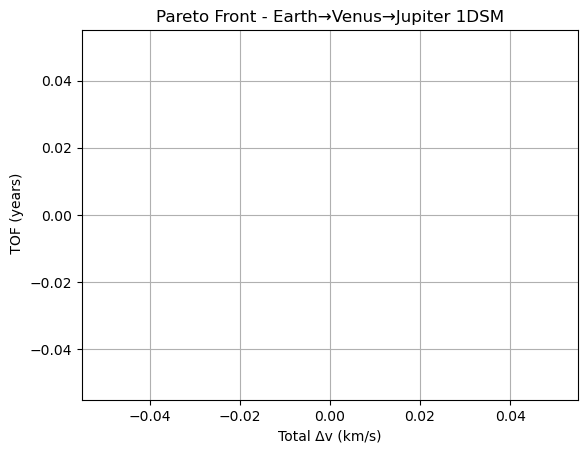

In [12]:
# Create Pygmo set
prob = pg.problem(udp)

#print(prob)   # print check
#print("Lower bounds:", prob.get_lb())
#print("Upper bounds:", prob.get_ub())

# Choose optimization algorithm
uda = pg.sade(gen=10000)

# Initialize population and optimize
archi = pg.archipelago(algo=uda, prob=udp, n=500, pop_size=500)
print("Running a Self-Adaptive Differential Evolution Algorithm .... on 10 parallel islands")
for _ in range(30):
    archi.evolve()
    archi.wait()
# For single objective
#sols = archi.get_champions_f()
#idx = sols.index(min(sols))
#print("Done!! Solutions found are: ", archi.get_champions_f())
#udp.pretty(archi.get_champions_x()[idx])

#For multi-objective
#Initialize lists to store all f and x vectors
f_vectors = []
x_vectors = []

# Loop over each island's population
for isl in archi:
    pop = isl.get_population()
    f_vectors.extend(pop.get_f())  # Objective values
    x_vectors.extend(pop.get_x())  # Decision vectors

import matplotlib.pyplot as plt
#For Multi-objective
delta_v = [f[0]/1000 for f in f_vectors]
tof_years = [f[1]/365 for f in f_vectors]

dv_filtered = [dv for dv in delta_v if dv <= 10.0]
tof_filtered = [tof for dv, tof in zip(delta_v, tof_years) if dv <= 10.0]

plt.scatter(dv_filtered, tof_filtered)
plt.xlabel("Total Δv (km/s)")
plt.ylabel(" TOF (years)")
plt.title("Pareto Front - Earth→Venus→Jupiter 1DSM")
plt.grid(True)
plt.show()

In [52]:
delta_v = [f[0]  for f in f_vectors]  # m/s
tof_days = [f[1] for f in f_vectors]  # days

# Least delta v
min_dv_idx = delta_v.index(min(delta_v))
print("Least Delta-v trajectory:")
udp.pretty(x_vectors[min_dv_idx])

#shortest time of flight
min_tof_idx = tof_days.index(min(tof_days))
print("\n\nShortest TOF trajectory:")
udp.pretty(x_vectors[min_tof_idx])

#Balanced solution using normalization
import numpy as np

# Normalize delta_v and tof_days manually
dv_array = np.array(delta_v)
tof_array = np.array(tof_days)

dv_norm = (dv_array - dv_array.min()) / (dv_array.max() - dv_array.min())
tof_norm = (tof_array - tof_array.min()) / (tof_array.max() - tof_array.min())

# Compute Euclidean distance to (0, 0)
distances = np.sqrt(dv_norm**2 + tof_norm**2)

# Find the index of the knee point (closest to ideal)
knee_idx = distances.argmin()

print("\n\n---- Best Balanced (Knee) Trajectory ----")
udp.pretty(x_vectors[knee_idx])

Least Delta-v trajectory:
First Leg: earth to venus
Departure: 2037-Mar-17 15:58:04.945154 (13590.665335013355 mjd2000) 
Duration: 288.41123014774894days
VINF: 4.331277775914633 km/sec
DSM after 36.66610227189183 days
DSM magnitude: 4123.0751323174645m/s

leg no. 2: venus to jupiter
Duration: 1239.1829105097931days
Fly-by epoch: 2037-Dec-31 01:50:15.229919 (13879.076565161104 mjd2000) 
Fly-by radius: 29.297774113034922 planetary radii
DSM after 291.71076930327 days
DSM magnitude: 8645.215760064988m/s

Arrival at jupiter
Arrival epoch: 2041-May-23 06:13:38.697965 (15118.259475670897 mjd2000) 
Arrival Vinf: 6121.909127054099m/s
Total mission time: 4.182324820417637 years (1527.594140657542 days)


Shortest TOF trajectory:
First Leg: earth to venus
Departure: 2040-Oct-06 06:40:07.265570 (14889.277861870021 mjd2000) 
Duration: 101.99124949692981days
VINF: 6.092311592759123 km/sec
DSM after 56.418572468415285 days
DSM magnitude: 40815.08393251279m/s

leg no. 2: venus to jupiter
Duration: 30

In [18]:
# Getting the Keplarian elements from Earth-DSM1 arc 

# Get planet objects
earth = pk.planet.jpl_lp('earth')
venus = pk.planet.jpl_lp('venus')
jupiter = pk.planet.jpl_lp('jupiter')

# Best solution
x = archi.get_champions_x()[idx]
#print(x)

# Unpack solution form the x vectors and getting the launch epoch, time of flight for the first leg and the second leg
t0_mjd = x[0]
f_dsm1 = x[4]
tof1   = x[5]
vinf_mag = x[3]
dsm1_mag = x[6] # for some reason it is different here hence using the value from udp.pretty

# Epochs
t0 = pk.epoch(t0_mjd)
t_dsm = pk.epoch(t0_mjd + (f_dsm1 * tof1))

# Computing dt i.e. time of flight upto the DSM 1
dt_days = t_dsm.mjd2000 - t0.mjd2000
dt_sec = dt_days * 86400

# Get Earth state at t0
earth = jpl_lp('earth')
r0, v0 = earth.eph(t0)

# Add V∞ at departure (assume in the direction of v0)
vinf_dir = np.array(v0) / np.linalg.norm(v0)
v0_departure = np.array(v0) + vinf_mag * vinf_dir

# Propagate from t0 to t_dsm
r_dsm, v_dsm = pk.propagate_lagrangian(r0, v0_departure, dt_sec, pk.MU_SUN)

# Compute Keplerian elements of Earth → DSM arc
kep = pk.ic2par(r0, v0_departure, pk.MU_SUN)

# Print orbital elements
print(f"Elements for Earth -> DSM1 → SMA: {kep [0]/1000:.3f} km, ECC: {kep[1]:.4f}, INC: {kep[2]:.2f}°")
print(f"Elements for Earth -> DSM1 → RA: {kep[3]:.2f}°, AP: {kep[4]:.2f}°, TA: {kep[5]:.2f}°\n\n\n")

Elements for Earth -> DSM1 → SMA: 450241635.276 km, ECC: 0.6631, INC: 0.00°
Elements for Earth -> DSM1 → RA: 3.14°, AP: 2.40°, TA: -0.01°





In [19]:
# Getting the Keplarian elements from Venus-DSM2 arc

# Unpack solution form the x vectors and getting the launch epoch, time of flight for the first leg and the second leg
tof2 = x[9]
f_dsm2 = x[8]  # DSM fraction on leg 2 (Venus → Jupiter)
t_venus = pk.epoch(t0_mjd + tof1)
t_dsm2 = pk.epoch(t0_mjd + tof1 + (f_dsm2 * tof2))

# States
rV, vV = venus.eph(t_venus)
rJ, vJ = jupiter.eph(pk.epoch(t0_mjd + tof1 + tof2))

# Lambert Venus → Jupiter
lambert = pk.lambert_problem(rV, rJ, (tof2 * 86400), pk.MU_SUN)
v_post_venus = lambert.get_v1()[0]

# Propagate Venus → DSM2
dt_dsm2 = (t_dsm2.mjd2000 - t_venus.mjd2000) * 86400
r_dsm2, v_dsm2 = pk.propagate_lagrangian(rV, v_post_venus, dt_dsm2, pk.MU_SUN)

# Orbital elements
kep_venus_dsm2 = pk.ic2par(rV, v_post_venus, pk.MU_SUN)


print(f"Elements for Venus -> DSM2 → SMA: {kep_venus_dsm2[0]/1000:.3f} km, ECC: {kep_venus_dsm2[1]:.4f}, INC: {kep_venus_dsm2[2]:.2f}°")
print(f"Elements for Venus -> DSM2 → RAAN: {kep_venus_dsm2[3]:.2f}°, AOP: {kep_venus_dsm2[4]:.2f}°, TA: {kep_venus_dsm2[5]:.2f}°")

Elements for Venus -> DSM2 → SMA: 480881048.811 km, ECC: 0.7771, INC: 0.07°
Elements for Venus -> DSM2 → RAAN: 5.81°, AOP: 2.65°, TA: -0.04°


In [1]:
# function for defining the values of the x vectors in a redable manner
# print(archi.get_champions_x()[idx])
def pretty_print_x(x):
    print("=== Decoded Decision Vector ===")
    print(f"Departure Epoch (MJD2000): {x[0]:.6f}")
    
    az_deg = math.degrees(x[1])
    el_deg = math.degrees(x[2])
    print(f"V_inf Azimuth (rad / deg): {x[1]:.6f} / {az_deg:.2f}°")
    print(f"V_inf Elevation (rad / deg): {x[2]:.6f} / {el_deg:.2f}°")
    
    print(f"Launch V∞ (m/s): {x[3]:.3f}")
    
    print("\n-- Leg 1: Earth → Venus --")
    print(f"When to do the DSM during Earth→Venus transfer: {(x[4]) *116.571: .3f}")
    print(f"TOF1 (days): {x[5]:.3f}")
    print(f"direction of DSM vector: {x[6]:.3f}")
    
    print("\n-- Venus Flyby --")
    print(f"Flyby Radius (planetary radii): {x[7]:.3f}")
    
    print("\n-- Leg 2: Venus → Jupiter --")
    print(f"When to do the DSM during Venus→Jupiter transfer: {x[8]*1496.500:.3f}")
    print(f"TOF2 (days): {x[9]:.3f}")
    
    total_tof = x[5] + x[9]
    print(f"\nTotal Mission TOF (days): {total_tof:.3f} days")
    print(f"Total Mission TOF (years): {total_tof / 365.25:.3f} years")

pretty_print_x(archi.get_champions_x()[idx])

NameError: name 'archi' is not defined